# Trabalho Prático III
Aluna: Cecília Kind

### Resumo:
O programa a seguir realiza o reconhecimento de captchas por meio da biblioteca de rede neural Keras. O trabalho foi divido em algumas etapas que serão abordadas passo a passo:

- 1: Obtenção dos labels
- 2: Obtenção das imagens
- 3: Remoção de ruído e divisão das imagens
- 4: Definição da arquitetura do modelo
- 5: Realização do treinamento e validação
- 6: Realização do teste
- 7: Análise dos resultados

### Bibliotecas:

In [1]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist

### Variáveis e estruturas auxiliares:

In [2]:
# Diretórios dos captchas
dir_treino = 'dados/CAPTCHA-10k/treinamento/*.jpg'
dir_validacao = 'dados/CAPTCHA-10k/validacao/*.jpg'
dir_teste = 'dados/CAPTCHA-10k/teste/*.jpg'

# Definição da faixa de valores para os labels
numberOfLabels = 59412
y_treino_start = 0
y_treino_finish = 47412
y_validacao_start = 47412
y_validacao_finish = 53412
y_teste_start = 53412
y_teste_finish = 59412

# Dicionário para mapear as letras para inteiros e seu reverso
char_to_int = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8,'9':9,
            'A':10, 'B':11, 'C':12, 'D':13, 'E':14, 'F':15, 'G':16, 'H':17,
            'I':18, 'J':19, 'K':20, 'L':21, 'M':22, 'N':23, 'O':24, 'P':25,
            'Q':26, 'R':27, 'S':28, 'T':29, 'U':30, 'V':31, 'W':32, 'X':33,
            'Y':34, 'Z':36}

int_to_char = {value : key for (key, value) in char_to_int.items()}

# Função para obter label da imagem
def predicted_label(i, labels, int_to_char):
    aux = i*6
    predicted_label = ""
    for i in range(aux,aux+6):
        predicted_label += (int_to_char[labels[i]])
    return predicted_label

### 1: Obtenção dos labels

- Leitura dos labels para treino, validação e teste
- A estrutura dos labels é modificada de um array de uma dimensão para 37 dimensões de forma a indicar a classificação do caractere entre todas as 37 opções. 

In [3]:
labels = np.empty(numberOfLabels)
count = 0

for file in sorted(glob.glob('dados/CAPTCHA-10k/labels10k/*.txt')):
    with open(file, 'rt') as fd:
        first_line = fd.readline()
        for char in range(6):
            labels[count] = char_to_int[first_line[char]]
            count+=1

#Divisão dos labels e conversão de 1 classe de saída para 37 
y_treino = labels[y_treino_start:y_treino_finish]
Y_treino = np_utils.to_categorical(y_treino, 37)

y_validacao = labels[y_validacao_start:y_validacao_finish]
Y_validacao = np_utils.to_categorical(y_validacao, 37)

y_teste = labels[y_teste_start:y_teste_finish]
Y_teste = np_utils.to_categorical(y_teste, 37)

print("Label para a primeira imagem:", labels[0:6], "\n")
print("Primeiro caractere do treino:", int_to_char[y_treino[0]], "\n")
print("Representação do primeiro caractere como classificação de 37 classes: \n", Y_treino[0], "\n")

Label para a primeira imagem: [27. 23. 18. 23. 18. 12.] 

Primeiro caractere do treino: R 

Representação do primeiro caractere como classificação de 37 classes: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



### 2: Obtenção das imagens

Imagens originais: 


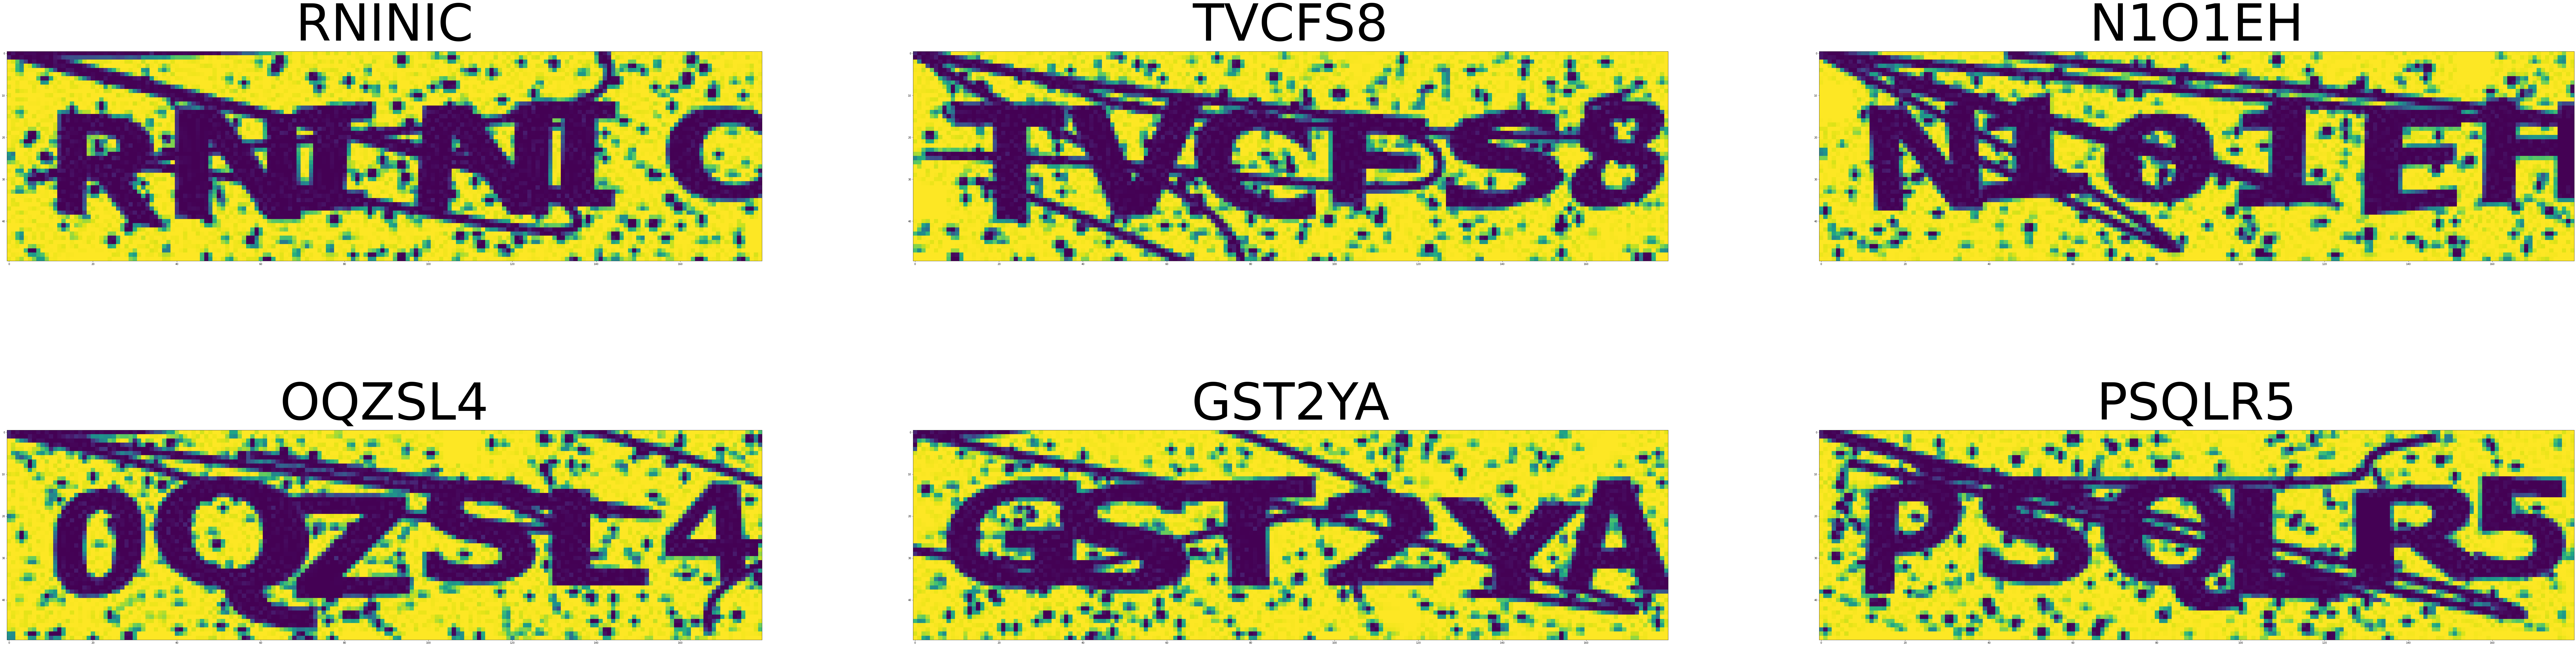

In [4]:
x_treino = [cv2.imread(file,0) for file in sorted(glob.glob(dir_treino))]
x_validacao = [cv2.imread(file,0) for file in sorted(glob.glob(dir_validacao))]
x_teste = [cv2.imread(file,0) for file in sorted(glob.glob(dir_teste))]

fig = plt.figure(figsize=(180,50))
columns = 3
rows = 2
for i in range(1,columns*rows +1):
    img = x_treino[i-1]
    x = fig.add_subplot(rows, columns, i)
    x.set_title(predicted_label(i-1, y_treino, int_to_char), fontsize = 200)
    plt.imshow(img)
print("Imagens originais: ")
plt.show()

### 3: Remoção de ruído e divisão das imagens

Antes de iniciar o processo de treinamento da rede foi necessário diminuir o ruído dos captchas e dividir cada uma das imagens entre os 6 caracteres que a formavam. A função clean_and_divide_x é responsável por realizar esse pré-processamento, seguindo os passos a seguir que são mostrados separadamente:

- A remoção dos ruídos é feita por meio das operações closing, erosion e dilation
    - Erosion: Corrói os limites do objeto em primeiro plano, diminuindo as características da imagem.
    - Dilation: Aumenta a área do objeto, acentuando características
    - Closing: Dilation seguido por erosion
- A escolha dos valores para kernel e a ordem das operações aplicadas para a remoção de ruído foram determinadas de forma experimental, buscando a maior clareza na compreensão dos caracteres. Apesar das imagens obtidas não apresentarem uma diferença marcante entre elas, o resultado obtido com a remoção de qualquer uma dessas operações resultou em uma diminuição na acurácia final.

Closing:

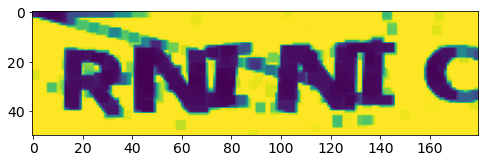

In [79]:
kernel = np.ones((4,4),np.uint8)
closing = cv2.morphologyEx(x_treino[0], cv2.MORPH_CLOSE, kernel)
plt.imshow(closing);

Dilation:

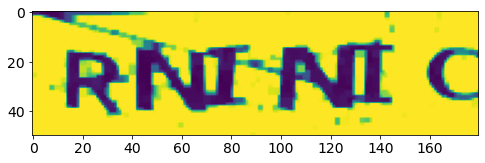

In [80]:
kernel = np.ones((3,3),np.uint8)
img_clean = cv2.dilate(closing,kernel,iterations = 1)
plt.imshow(img_clean);

- Um equívoco cometido no trabalho foi a tentativa de tornar os captchas mais reconhecíveis ao olho humano, desconsiderando que a rede neural consegue por meio do aprendizado identificar as letras mesmo que "imperfeitas", desde que seja mantido o padrão das entradas. Por exemplo, a binarização foi aplicada inicialmente na tentativa de diminuir o ruído após o uso das operações erosion e dilation. Apesar de tornar a leitura mais fácil, o resultado apresentado pela rede foi inferior ao teste sem a binarização. Mesmo com a diminuição do ruído, os caracteres ficaram mais deformados, o que acabou prejudicando o aprendizado da rede. Após a remoção da binarização, houve um aumento de 2% na acurácia da validação, subindo de 93% para 95%.

Binarização:

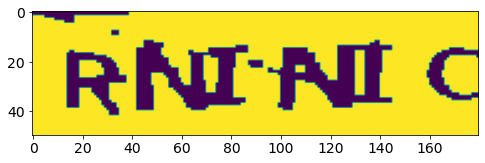

In [81]:
binar = cv2.threshold(img_clean, 0, 100, cv2.THRESH_OTSU)[1]
plt.imshow(binar);

- A divisão das imagens também foi realizada de forma experimental. Após a observação de vários captchas, foi identificado que os caracteres eram na maioria das vezes posicionados no mesmo lugar. Assim, cada imagem foi dividida em 6 retângulos de 30x28 correspondentes à posição aproximada de cada um dos caracteres. Em muitos casos a divisão foi satisfatória e em outros nem tanto, o que pode ter contribuído para a diminuição da acurácia da rede.

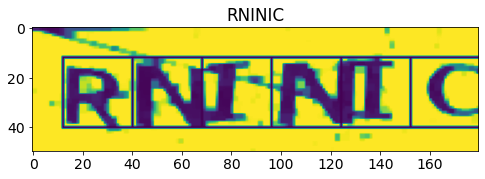

In [90]:
x1 = 12
x2 = 40
for i in range(6):
    cv2.rectangle(img_clean, (x1, 12), (x2, 40), (0,255,0),1)
    x1 = x2
    x2+=28

plt.title(predicted_label(0, y_treino, int_to_char))
plt.imshow(img_clean);

Exemplo de divisão errada: o W é cortado na metade

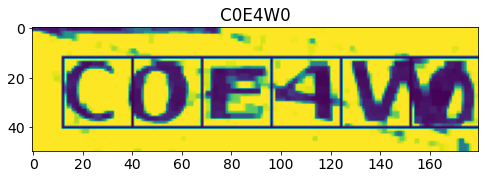

In [89]:
kernel = np.ones((4,4),np.uint8)
div_errada = cv2.morphologyEx(x_treino[147], cv2.MORPH_CLOSE, kernel)
kernel = np.ones((3,3),np.uint8)
div_errada = cv2.dilate(div_errada,kernel,iterations = 1)

x1 = 12
x2 = 40
for i in range(6):
    cv2.rectangle(div_errada, (x1, 12), (x2, 40), (0,255,0),1)
    x1 = x2
    x2+=28

plt.title(predicted_label(147, y_treino, int_to_char))
plt.imshow(div_errada);

- clean_and_divide_x: Função responsável pela remoção de ruído e divisão dos caracteres de acordo com os passos demonstrados anteriormente.

In [24]:
def clean_and_divide_x(img_data, size):
    
    # Estrutura para armazenar as imagens dos caracteres
    list_img_char = np.empty([6*size, 30, 28])
    count = 0
    
    # Redução de ruído e divisão de cada imagem
    for img in img_data:
        kernel = np.ones((4,4),np.uint8)
        closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        kernel = np.ones((3,3),np.uint8)
        img_clean = cv2.dilate(closing,kernel,iterations = 1)
        #img_clean = cv2.threshold(img_clean, 0, 100, cv2.THRESH_OTSU)[1]
        
    
        x1 = 12
        x2 = 40
        for i in range(6):
            p1 = img_clean[12:42,x1:x2]
            x1 = x2
            x2+=28
            list_img_char[count] = p1
            count+=1
    
    return list_img_char

- Chamada para clean_and_divide_x para treinamento, validação e teste
- Normalização dos dados

In [25]:
X_treino = clean_and_divide_x(x_treino, 7902)
X_treino = X_treino.reshape(X_treino.shape[0], 30, 28, 1)
X_treino = X_treino.astype('float32')
X_treino /= 255

X_validacao = clean_and_divide_x(x_validacao, 1000)
X_validacao = X_validacao.reshape(X_validacao.shape[0], 30, 28, 1)
X_validacao = X_validacao.astype('float32')
X_validacao /= 255

X_teste = clean_and_divide_x(x_teste, 1000)
X_teste = X_teste.reshape(X_teste.shape[0], 30, 28, 1)
X_teste = X_teste.astype('float32')
X_teste /= 255

- Exemplos dos resultados obtidos após a diminuição de ruídos e segmentação.

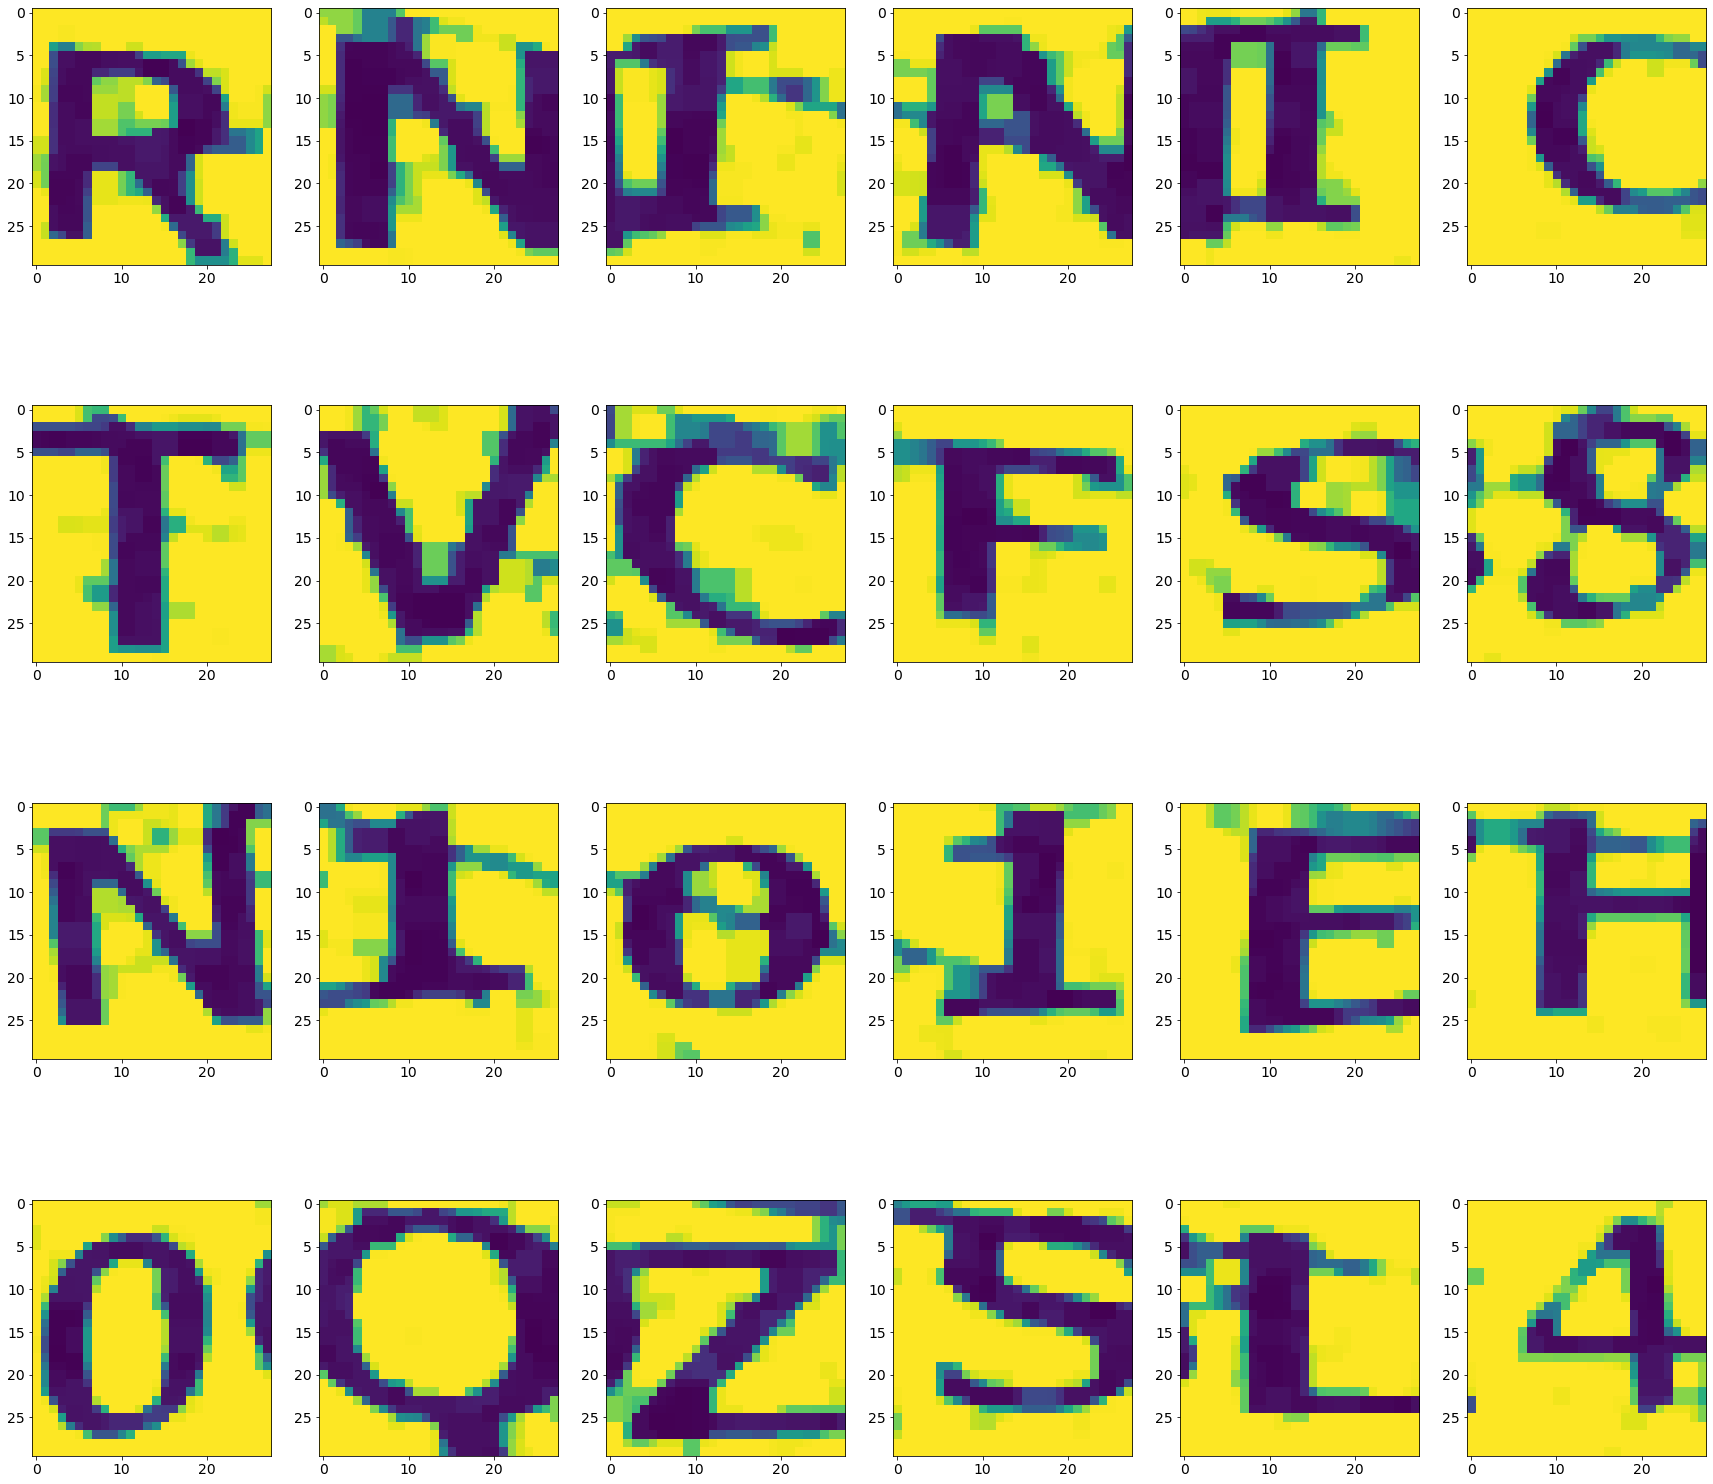

In [26]:
fig = plt.figure(figsize=(30, 28))
columns = 6
rows = 4
for i in range(1,columns*rows +1):
    img = X_treino[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

### 4: Definição da arquitetura do modelo

O modelo escolhido foi baseado no modelo estudado em sala, a rede neural convolucional simples Lenet-5. O número de camadas e os valores definidos foram escolhidos de forma experimental e buscando a simplicidade do modelo. Durante os testes, foi decidido abrir mão de um resultado um pouco melhor em troca de um modelo com metade do número de parâmetros. A arquitetura consiste em 4 camadas convolucionais e 2 camadas fully connected, e os detalhes são apresentados a seguir.  

Arquitetura:
- Camada de entrada: 
    - 1: 50 filtros convolucionais 3x3
    - Max Pooling 2x2
- Hidden Layers:
    - 2: 40 filtros convolucionais 3x3
    - Max Pooling 3x3
    - Dropout 0.25
    - 3: 90 filtros convolucionais 3x3
    - Dropout 0.25
    - 4: 40 filtros convolucionais 3x3
    - Dropout 0.25
- Fully connected layer
    - 5: 100 filtros
    - Dropout 0.5
    - 6: 37 filtros -> ativação soft max
    

In [27]:
model = Sequential()

# CNN input layer
model.add(Conv2D(50, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(30,28,1)))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#hiden layers
model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model.add(Dropout(0.25))

model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))

# fully connected layer
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(37, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 28, 50)        500       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 14, 50)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 14, 40)        18040     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 40)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 40)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 90)          32490     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 90)         

### 5: Realização do treinamento e validação

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
%%time
response = model.fit(X_treino, Y_treino,validation_data=(X_validacao, Y_validacao), 
          batch_size=128, epochs=10, verbose=1)

Epoch 1/10
371/371 [==============================] - 51s 134ms/step - loss: 1.6262 - accuracy: 0.5191 - val_loss: 0.3760 - val_accuracy: 0.8740
Epoch 2/10
371/371 [==============================] - 49s 132ms/step - loss: 0.5185 - accuracy: 0.8330 - val_loss: 0.2423 - val_accuracy: 0.9183
Epoch 3/10
371/371 [==============================] - 49s 132ms/step - loss: 0.3834 - accuracy: 0.8777 - val_loss: 0.2093 - val_accuracy: 0.9323
Epoch 4/10
371/371 [==============================] - 48s 129ms/step - loss: 0.3276 - accuracy: 0.8967 - val_loss: 0.1757 - val_accuracy: 0.9432
Epoch 5/10
371/371 [==============================] - 48s 129ms/step - loss: 0.2861 - accuracy: 0.9101 - val_loss: 0.1755 - val_accuracy: 0.9403
Epoch 6/10
371/371 [==============================] - 47s 128ms/step - loss: 0.2686 - accuracy: 0.9154 - val_loss: 0.1623 - val_accuracy: 0.9508
Epoch 7/10
371/371 [==============================] - 47s 128ms/step - loss: 0.2435 - accuracy: 0.9236 - val_loss: 0.1591 - val_ac

### 6: Realização do teste

In [30]:
score = model.evaluate(X_teste, Y_teste, verbose=1)

188/188 [==============================] - 2s 13ms/step - loss: 0.1723 - accuracy: 0.9505


### 7: Análise dos resultados

- Além do valor da acurácia, era importante identificar se o número de parâmetros envolvidos na rede estava muito elevado, ou se era possível diminuir este número sem prejudicar a acurácia do modelo. Para avaliar o resultado, a razão Acurácia / Número de parâmetros foi observada. Em um primeiro momento, uma acurácia 1% maior na avaliação foi obtida com o dobro dos parâmetros utilizados, o que tornou a razão calculada muito pequena. Assim, optou-se por diminuir um pouco a acurácia para manter a simplicidade do modelo sem prejudicar muito sua performance.

In [39]:
num_param = 187.307
accuracy = score[1]
print(accuracy/num_param)

0.005074556804839605


- A seguir são apresentadas algumas classificações obtidas pelo modelo nas imagens de teste.

In [40]:
predictions = model.predict(X_teste)
classes = np.argmax(predictions, axis = 1)

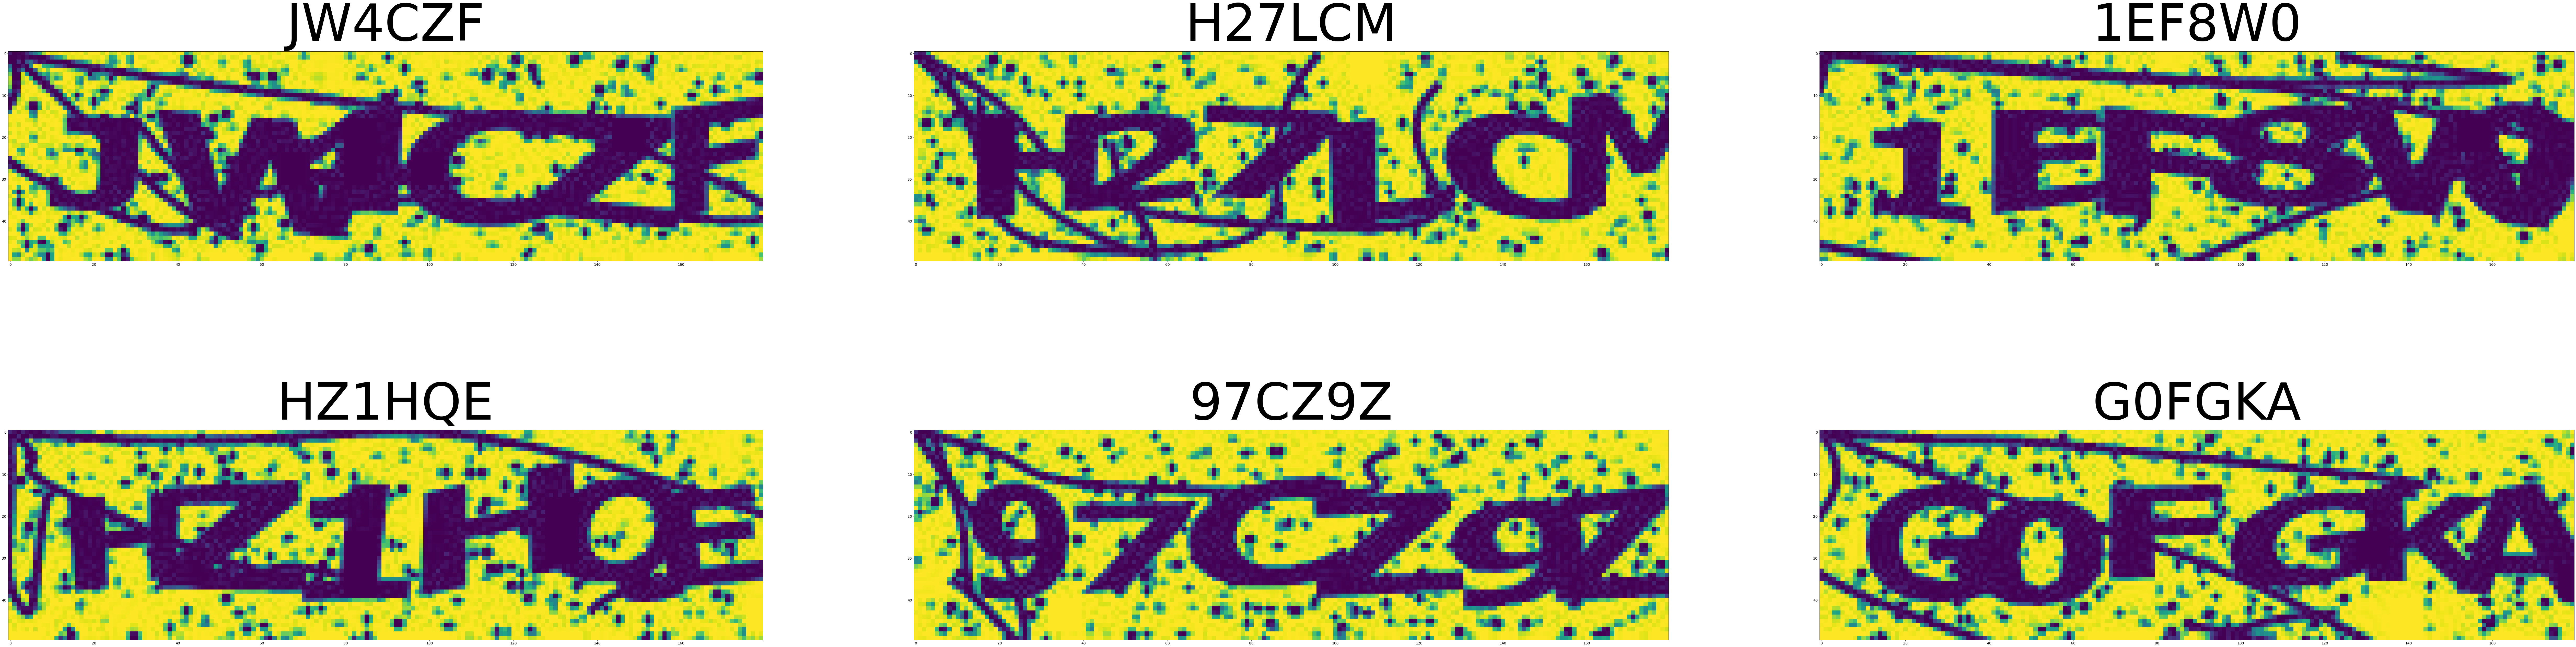

In [41]:
predict_Y = classes[0:6]
real_Y = y_teste[0:6]

def predicted_label(i, classes, int_to_char):
    aux = i*6
    predicted_label = ""
    for i in range(aux,aux+6):
        predicted_label += (int_to_char[classes[i]])
    return predicted_label
    
fig = plt.figure(figsize=(180,50))
columns = 3
rows = 2
for i in range(1,columns*rows +1):
    img = x_teste[i-1]
    x = fig.add_subplot(rows, columns, i)
    x.set_title(predicted_label(i-1, classes, int_to_char), fontsize = 200)
    plt.imshow(img)
plt.show()

Os resultados obtidos podem ser visualizados de forma melhor por meio do gráfico a seguir, que mostra a taxa de reconhecimento do modelo em função do número mínimo de caracteres que foram corretamente reconhecidos por captcha. O ideal seria ter o valor de y = 1 para todos os valores de x, o que indicaria um acerto de 100% dos caracteres. No entanto, o resultado obtido foi inferior, reconhecendo os 6 captchas em apenas 75% dos casos aproximadamente, e em alguns casos não chegou a reconhecer 5. Alguns dos motivos que podem ter contribuído para este resultado são a simplicidade do modelo,  a divisão manual para separar os caracteres que não foi correta em todos os casos e a incapacidade de remover os ruídos de forma eficiente.

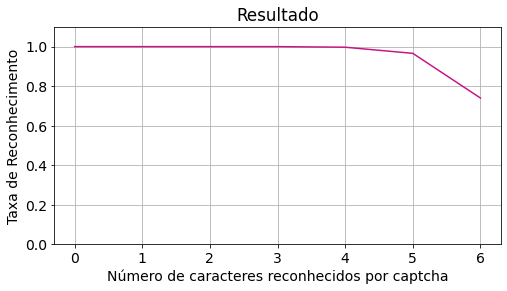

In [58]:
accuracy_dict = dict([(0,0), (1,0), (2,0), (3,0), (4,0), (5,0), (6,0)])
hist_dict = dict([(0,0), (1,0), (2,0), (3,0), (4,0), (5,0), (6,0)])
total_sum = 0

for i in range (0,6000,6):
    sum = 0
    for j in range(6):
        if classes[i+j] == y_teste[i+j]:
            total_sum += 1
            sum += 1
    hist_dict[sum] += 1
    for i in range(0,sum+1):
        accuracy_dict[i] += 1
    
for key, value in accuracy_dict.items():
    accuracy_dict[key] = accuracy_dict[key]/1000
lists = sorted(accuracy_dict.items())

plt.rcParams.update({'font.size':14})
plt.rcParams["figure.figsize"] = (8,4)
x, y = zip(*lists)
fig, ax = plt.subplots()
plt.title("Resultado")
ax.set_ylim(bottom=0, top=1.1)
plt.xlabel("Número de caracteres reconhecidos por captcha")
plt.ylabel("Taxa de Reconhecimento")
plt.grid()
plt.plot(x, y, color = 'mediumvioletred')
plt.show()


Outra forma de visualizar os resultados é demonstrada a seguir. No caso, o gráfico em barra indica em y o número exato de captchas no teste em que foram reconhecidos o número de caracteres descrito em x. Apesar do resultado não ter sido execelente em função das condições impostas, os resultados obtidos são satisfatórios. Mesmo com a simplicidade do modelo, a divisão manual do caracteres, as escolhas tomadas de forma experimental e a inexperiência no desenvolvimento de redes neurais, foi possível prever corretamente 95% dos caracteres e acertar na maioria dos casos os 6 caracteres. 

In [62]:
print("Porcentagem de acerto para todos os caracteres: ", total_sum/6000)

Porcentagem de acerto para todos os caracteres:  0.9505


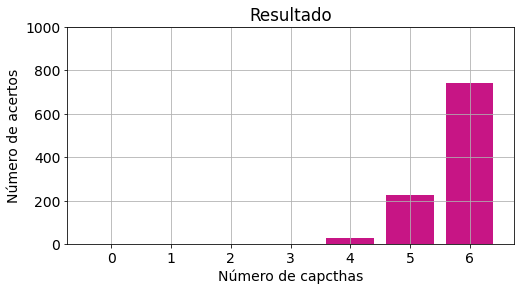

In [61]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=0, top=1000)
plt.title("Resultado")
plt.grid()
plt.xlabel("Número de capcthas")
plt.ylabel("Número de acertos")
plt.bar(list(hist_dict.keys()), hist_dict.values(), color='mediumvioletred')
plt.show()